In [1]:
# Importing relevant libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from geopy.distance import distance
from datetime import datetime

In [2]:
working_directory = "C:\Projects\AkzoNobel interview presentation\data"
os.chdir(working_directory) # setting up the working directory

In [3]:
data = pd.read_csv("Transformed data.csv") # importing the dataset

In [4]:
data.head(1)

,Unnamed: 0,Datetime,Speed Through Water [kts],Shaft Power [kW],Fuel Oil Cons. [kg/hour],Shaft Speed [RPM],Torque [nM],Wind Speed Abs. [kts],Speed Over Ground [kts],Draft Aft [m],...,month,year,hour,minute,second,location,distance covered (nmi),time elapsed (hrs),fuel efficiency,hull stability
0,1,2018-07-19 01:00:00,10.663333,6580.133333,1164.266667,42.005833,1495.941667,12.165,11.729167,20.455,...,7,2018,1,0,0,"(6.0, 96.675)",40.35192,1.0,34.658658,0.090833


#### 1. Mean stability at different months of the year

In [5]:
# Creating a month names array

month_names = ["Jan", "Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]

In [6]:
# Creating a month wise grouped dataframe to plot

pdf1 = data.groupby(["month"])["hull stability"].mean().reset_index(name="mean stability")

([<matplotlib.axis.XTick at 0x28ca718b3a0>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Feb'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Apr'),
  Text(5, 0, 'May'),
  Text(6, 0, 'Jun'),
  Text(7, 0, 'Jul'),
  Text(8, 0, 'Aug'),
  Text(9, 0, 'Sept'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Dec')])

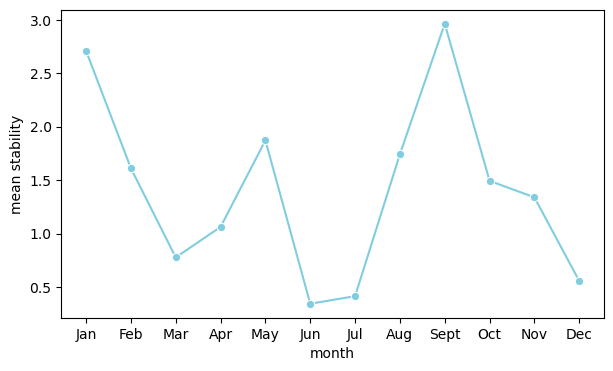

In [7]:
# Plotting

plt.figure(figsize=(7,4))
sb.lineplot(data=pdf1,x="month",y="mean stability", marker="o", color = "#80cde0")
plt.xticks(sorted(data["month"].unique()),month_names)

The average stability of the ship for each month is calculated and the values are plotted in the graph.

We may see the graph peaking at certain parts of the year, which might be the indication of magnitude of loading and unloading of goods from the ship at those periods.


#### 2. Effect of windspeed in fuel consumption

In [8]:
# creating a flag column to check whether the wind speed is greater than speed through water or not
# 0 -> windspeed <= speed through water 
# 1 -> windspeed > speed through water 

df2 = data

df2["difference"] = df2["Wind Speed Abs. [kts]"] - df2["Speed Through Water [kts]"]

def effects_checker(x):
    if(x<=0):
        return 0
    else:
        return 1
    
df2["effects_flag"] = df2["difference"].apply(effects_checker)

In [9]:
pdf2 = df2.groupby(["effects_flag"])["Fuel Oil Cons. [kg/hour]"].mean().reset_index(name = "mean fuel consumption per hour")

In [10]:
pdf2

,effects_flag,mean fuel consumption per hour
0,0,1835.163696
1,1,1679.862464


Text(0.5, 0, 'condition')

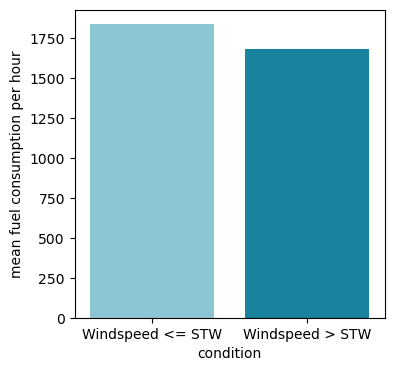

In [11]:
plt.figure(figsize=(4,4))
sb.barplot(data = pdf2, x="effects_flag",y="mean fuel consumption per hour", palette=["#80cde0", "#038FB2"])
plt.xticks(pdf2["effects_flag"], ["Windspeed <= STW", "Windspeed > STW"])
plt.xlabel("condition")

There was no direct significant correlation between the windspeed and fuel consumption when observed through a correlation plot. 

Therefore, to investigate the influence of wind speed, the dataset was split into two subgroups. One of which contained instances where the wind speed was equal to or less than the ship's speed through water, while the other subset comprised data points where the wind speed exceeded the ship's speed through water.

A comparison bar plot is plotted to show the average fuel consumption in both the cases. We may observe that when the windspeed is greater than the speed through water, the fuel consumed by the ship is relatively low.


#### 3. Difference between calculated power and power recorded

In [12]:
df3 = df2 # checkpoint

In [13]:
df3["power calculated"] = (df3["Torque [nM]"]*2*np.pi*df3["Shaft Speed [RPM]"])/60
df3["power difference"] = df3["Shaft Power [kW]"] - df3["power calculated"]

<AxesSubplot:xlabel='power difference', ylabel='Density'>

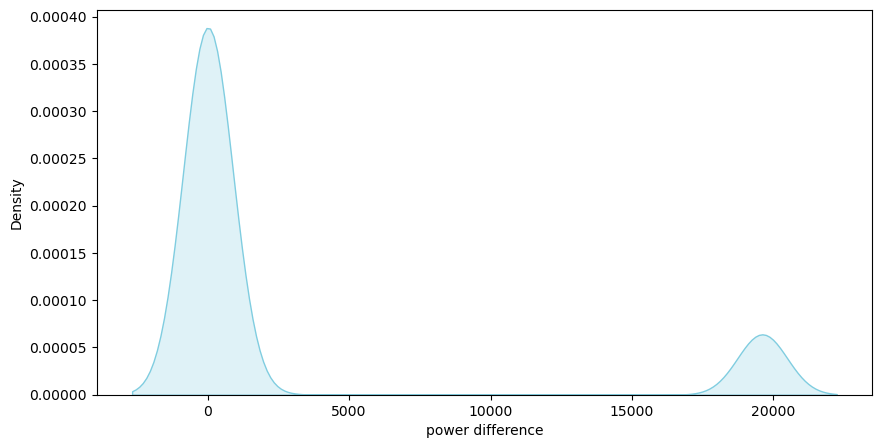

In [14]:
plt.figure(figsize=(10,5))
sb.kdeplot(data=df3, x="power difference", color = "#80cde0", fill=True)

To investigate any machine errors in the readings in the dataset, I manually computed the Shaft power using the Shaft speed and Shaft Torque.

The relationship is, Power = (Torque x 2π x speed) / 60

The difference between calculated power and observed power was calculated, and a distribution graph was plotted.

In the graph, we may observe that for a certain group of readings, the error values are very high (close to 20000 KW). 

To examine further on these error values, I inspected the Torque and Speed values, associated with these readings 


In [15]:
pdf3 = df3[df3["power difference"]>10000]

In [16]:
pdf3["Datetime"] = pd.to_datetime(pdf3["Datetime"])

C:\Users\rdivy\AppData\Local\Temp\ipykernel_25668\2697205624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf3["Datetime"] = pd.to_datetime(pdf3["Datetime"])


<AxesSubplot:xlabel='Datetime', ylabel='Shaft Speed [RPM]'>

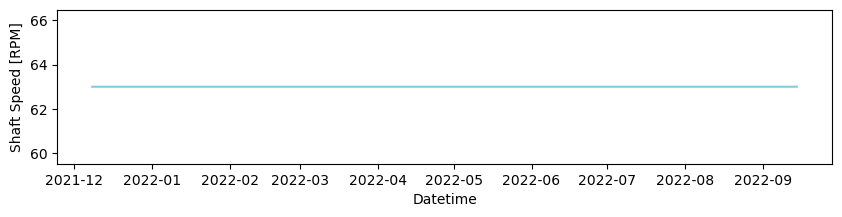

In [17]:
plt.figure(figsize=(10,2))
sb.lineplot(data = pdf3, y="Shaft Speed [RPM]",x="Datetime", color = "#80cde0")

<AxesSubplot:xlabel='Datetime', ylabel='Torque [nM]'>

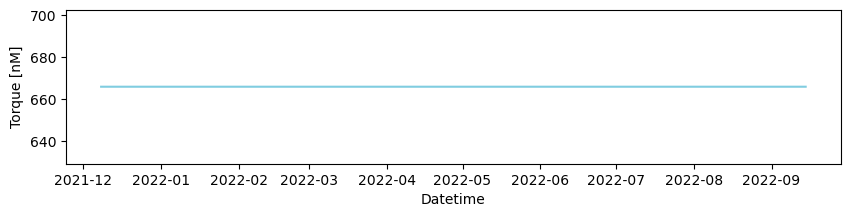

In [18]:
plt.figure(figsize=(10,2))
sb.lineplot(data = pdf3, y="Torque [nM]",x="Datetime", color = "#80cde0")

The values of Torque and Shaft speed was found to be a constant value for all these readings.

One possible reason behind this could be that these observed torque or speed values may represent the maximum capacity of the meter in which they are recorded. Whenever the ship experiences a value exceeding the meter's range, the machine might have provided the maximum value within its operational limits.

#### 4. Effect of Speed of water on fuel consumption

In [19]:
df4 = df3 # checkpoint

In [20]:
df4["speed of current"] = df4["Speed Over Ground [kts]"]-df4["Speed Through Water [kts]"]

Text(0.5, 0, 'Speed of current [kts]')

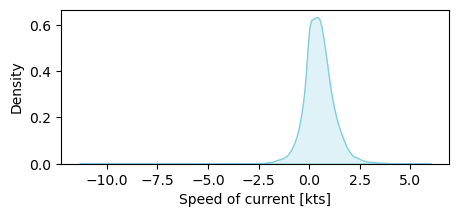

In [21]:
plt.figure(figsize=(5,2))
sb.kdeplot(x=df4["speed of current"], color="#80cde0", fill=True)
plt.xlabel("Speed of current [kts]")

The graph depicts the distribution curve of the speed of the current.

The speed of the current is calculated using the difference between the speed of ship over ground and speed of ship relative to water.

The range of speed of current was observed to be (-11.08, 5.74) in knots.
